In [1]:
import skimage
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [2]:
image_paths = glob.glob("Deep/pics/*.png")
print("Total Observations:\t", len(image_paths))

data = pd.read_csv("Deep/data.csv")
colour_lookup = data.colour.unique()
labels, _ = pd.factorize(data.colour)
data.colour = labels

X_train, X_test, y_train, y_test = train_test_split(data.id, data, test_size=0.2, random_state=42, stratify=data.colour)
X_test, X_valid, y_test, y_valid = train_test_split(y_test.id, y_test, test_size=0.5, random_state=42, stratify=y_test.colour)

train_images_paths = ['Deep/pics/{}.png'.format(i) for i in X_train.values]
test_images_paths = ['Deep/pics/{}.png'.format(i) for i in X_test.values]
valid_images_paths = ['Deep/pics/{}.png'.format(i) for i in X_valid.values]

print("Training data length:\t", len(train_images_paths))
print("Test data length:\t", len(test_images_paths))
print("Validation data length:\t", len(valid_images_paths))
print("Training target shape:\t", y_train.shape)
print("Test target shape:\t", y_test.shape)
print("Validation target shape:", y_valid.shape)

Total Observations:	 3508
Training data length:	 2806
Test data length:	 351
Validation data length:	 351
Training target shape:	 (2806, 5)
Test target shape:	 (351, 5)
Validation target shape: (351, 5)


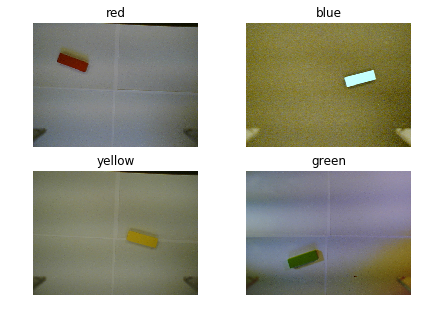

In [411]:
blocks = np.array(y_train.colour.unique())
blocks_examples = [np.random.choice(y_train[y_train.colour == b].id.values) for b in blocks]

indexes = [image_paths.index('Deep/pics\\{}.png'.format(i)) for i in blocks_examples]

fig = plt.figure(figsize=(7, 5))
for i, idx in enumerate(indexes):
    plt.subplot(2, 2, i + 1)
    image = imread(image_paths[idx], as_gray=False)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (colour_lookup[blocks[i]]))
    plt.axis('off')
plt.show()

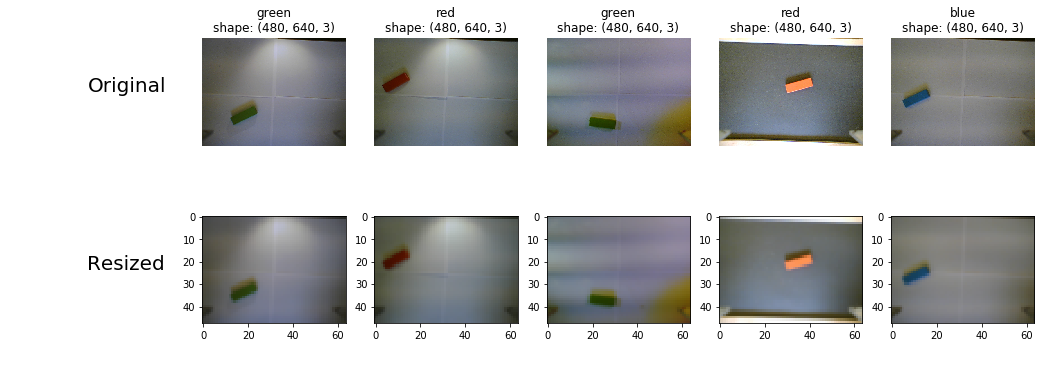

In [4]:
## Image pre-processing
image_size = (48, 64, 3)

fig = plt.figure(figsize=(18, 6))
amount = 5
image_sample = np.random.choice(train_images_paths, amount)
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=False)
    plt.imshow(image)
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(colour_lookup[y_train[y_train.id == _id].colour.values[0]], image.shape))
    plt.axis('off')
    
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=False)
    image = resize(image, output_shape=image_size[:2], mode='reflect', anti_aliasing=True)  # resizes the image  # , anti_aliasing=True
    plt.imshow(image, cmap='gray')
    
plt.show()

In [5]:
# Loading of training, testing and validation images into lists:
print("LOADING TRAINING IMAGES")
train_images = [imread(file) for file in train_images_paths]
print("\t..done.. Amount:", len(train_images), "Shape:", train_images[0].shape)
print("LOADING TEST IMAGES")
test_images = [imread(file) for file in test_images_paths]
print("\t..done.. Amount:", len(test_images), "Shape:", test_images[0].shape)
print("LOADING VALIDATION IMAGES")
valid_images = [imread(file) for file in valid_images_paths]
print("\t..done.. Amount:", len(valid_images), "Shape:", valid_images[0].shape)

LOADING TRAINING IMAGES
	..done.. Amount: 2806 Shape: (480, 640, 3)
LOADING TEST IMAGES
	..done.. Amount: 351 Shape: (480, 640, 3)
LOADING VALIDATION IMAGES
	..done.. Amount: 351 Shape: (480, 640, 3)


In [6]:
# Resizing the images to the found size (48x64)
print("RESIZING TRAINING IMAGES")
train_images = [resize(img, output_shape=image_size, mode='reflect', anti_aliasing=True) for img in train_images]
print("\t..done.. Amount:", len(train_images), "Shape:", train_images[0].shape)
print("RESIZING TEST IMAGES")
test_images = [resize(img, output_shape=image_size, mode='reflect', anti_aliasing=True) for img in test_images]
print("\t..done.. Amount:", len(test_images), "Shape:", test_images[0].shape)
print("RESIZING VALIDATION IMAGES")
valid_images = [resize(img, output_shape=image_size, mode='reflect', anti_aliasing=True) for img in valid_images]
print("\t..done.. Amount:", len(valid_images), "Shape:", valid_images[0].shape)

RESIZING TRAINING IMAGES
	..done.. Amount: 2806 Shape: (48, 64, 3)
RESIZING TEST IMAGES
	..done.. Amount: 351 Shape: (48, 64, 3)
RESIZING VALIDATION IMAGES
	..done.. Amount: 351 Shape: (48, 64, 3)


In [7]:
# Convert to numpy arrays
train_images = np.array(train_images)
valid_images = np.array(valid_images)
test_images = np.array(test_images)
print("Shapes: ",train_images.shape,valid_images.shape,test_images.shape)

Shapes:  (2806, 48, 64, 3) (351, 48, 64, 3) (351, 48, 64, 3)


In [8]:
# Move channel axis
train_images = np.moveaxis(np.array(train_images),3,1)
valid_images = np.moveaxis(np.array(valid_images),3,1)
test_images = np.moveaxis(np.array(test_images),3,1)
print("Shapes: ",train_images.shape,valid_images.shape,test_images.shape)

Shapes:  (2806, 3, 48, 64) (351, 3, 48, 64) (351, 3, 48, 64)


In [9]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, Dropout
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

# Colour identification model

In [390]:
"""
COLOUR IDENTIFICATION MODEL (CLASSIFICATION)
"""

num_classes = len(colour_lookup)
channels = train_images[0].shape[0]
height = train_images[0].shape[1]
width = train_images[0].shape[2]

conv1_out = 12
conv1_kern = 4
conv1_stri = 1

maxp1_kern = 3
maxp1_stri = 2

conv2_out = 48
conv2_kern = 4
conv2_stri = 1

maxp2_kern = 2
maxp2_stri = 2

l1_out = 500
   
def compute_conv_dim(dim_size, kern_size, stride, padd = 0):
    return int((dim_size - kern_size + 2 * padd) / stride + 1)

class Net_Colour_ID(nn.Module):

    def __init__(self):
        super(Net_Colour_ID, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv1_out,
                             kernel_size=conv1_kern,
                             stride=conv1_stri,
                             bias=True)
        
        self.maxp_1 = MaxPool2d(kernel_size=maxp1_kern,stride=maxp1_stri)
        
        self.conv_2 = Conv2d(in_channels=conv1_out,
                             out_channels=conv2_out,
                             kernel_size=conv2_kern,
                             stride=conv2_stri,
                             bias=True)
        
        self.maxp_2 = MaxPool2d(kernel_size=maxp2_kern,stride=maxp2_stri)
        
        h = compute_conv_dim(height, conv1_kern, conv1_stri) # conv1
        h = compute_conv_dim(h, maxp1_kern, maxp1_stri)      # maxp1
        h = compute_conv_dim(h, conv2_kern, conv2_stri)      # conv2
        h = compute_conv_dim(h, maxp2_kern, maxp2_stri)      # maxp2
        
        w = compute_conv_dim(width, conv1_kern, conv1_stri)  # conv1
        w = compute_conv_dim(w, maxp1_kern, maxp1_stri)      # maxp1
        w = compute_conv_dim(w, conv2_kern, conv2_stri)      # conv2
        w = compute_conv_dim(w, maxp2_kern, maxp2_stri)      # maxp2
        
        c = conv2_out                                        # last amount of channels
        
        self.l_out_features = c * h * w
        
        self.l_1 = Linear(in_features=self.l_out_features, out_features=l1_out, bias=True)
        
        self.l_out = Linear(in_features=l1_out, out_features=num_classes, bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = relu(self.conv_1(x))
        x = self.maxp_1(x)
        x = relu(self.conv_2(x))
        x = self.maxp_2(x)
        x = x.view(-1, self.l_out_features)
        x = relu(self.l_1(x))
        x = F.dropout(x,0.5)
        return softmax(self.l_out(x), dim=1)


net = Net_Colour_ID()
print(net)

Net_Colour_ID(
  (conv_1): Conv2d(3, 12, kernel_size=(4, 4), stride=(1, 1))
  (maxp_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(12, 48, kernel_size=(4, 4), stride=(1, 1))
  (maxp_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_1): Linear(in_features=5616, out_features=500, bias=True)
  (l_out): Linear(in_features=500, out_features=4, bias=False)
)


In [391]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0005)

In [392]:
#Test of the forward pass with dummy data
x = np.random.normal(0,1, (5, image_size[2], image_size[0], image_size[1])).astype('float32')
out = net(Variable(torch.from_numpy(x)))
out.size(), out

(torch.Size([5, 4]), tensor([[0.2507, 0.2642, 0.2882, 0.1970],
         [0.2503, 0.2611, 0.2855, 0.2031],
         [0.2495, 0.2706, 0.2887, 0.1913],
         [0.2690, 0.2590, 0.2778, 0.1941],
         [0.2535, 0.2504, 0.2907, 0.2055]], grad_fn=<SoftmaxBackward>))

Epoch  1 : Train Loss 1.527884 , Train acc 0.406429, Valid acc 0.417143
Epoch  3 : Train Loss 1.180276 , Train acc 0.896071, Valid acc 0.914286
Epoch  5 : Train Loss 0.912819 , Train acc 0.962857, Valid acc 0.951429
Epoch  7 : Train Loss 0.881939 , Train acc 0.974643, Valid acc 0.968571
Epoch  9 : Train Loss 0.867077 , Train acc 0.991429, Valid acc 0.982857
Epoch 11 : Train Loss 0.859049 , Train acc 0.994286, Valid acc 0.994286
Epoch 13 : Train Loss 0.853633 , Train acc 0.991786, Valid acc 0.982857
Epoch 15 : Train Loss 0.848819 , Train acc 0.998214, Valid acc 0.997143
Epoch 17 : Train Loss 0.846220 , Train acc 0.998214, Valid acc 0.997143
Epoch 19 : Train Loss 0.851187 , Train acc 0.997857, Valid acc 0.997143

Test set Acc:  98.575499%


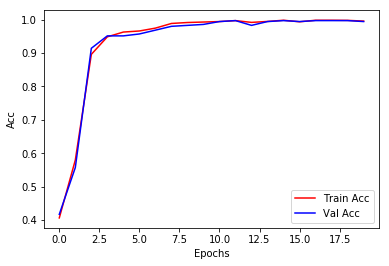

In [393]:
from sklearn.metrics import accuracy_score

batch_size = 50
num_epochs = 20
num_samples_train = train_images.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = valid_images.shape[0]
num_batches_valid = num_samples_valid // batch_size

targets_train = y_train.colour.values
targets_valid = y_valid.colour.values
targets_test = y_test.colour.values

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train_images[slce]).float())
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train_images[slce]).float())
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(valid_images[slce]).float())
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce])
        val_preds += list(preds.data.numpy())
        
    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 2 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(test_images).float())
output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f%%" % (accuracy_score(list(targets_test), list(preds.data.numpy()))*100))

## Test of model functionality with random samples from the test set

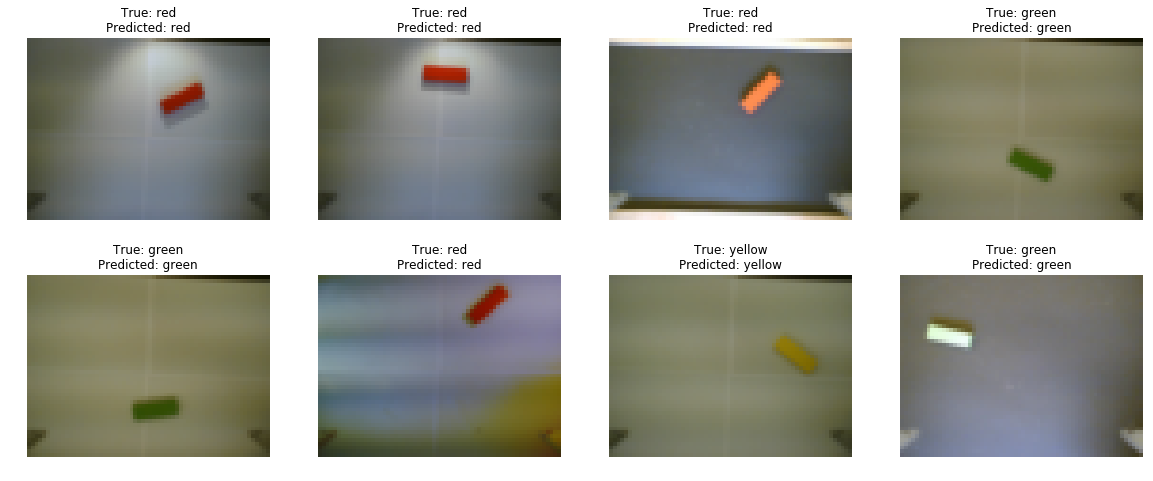

In [532]:
numberofimages = 8
imagesperline = 4
outtest = net(torch.Tensor(test_images))
idx = np.random.choice(range(len(outtest)),numberofimages)
outtest_sample = torch.max(outtest[idx],1)[1]
targets_test = y_test.colour.values
targets_test_sample = targets_test[idx]
fig = plt.figure(figsize=(20, 8))
l = len(outtest_sample)
for i in range(l):
    plt.subplot(l//imagesperline, imagesperline, i+1)
    plt.imshow(np.moveaxis(test_images[idx][i],0,2))
    plt.title("True: {0}\nPredicted: {1}".format(colour_lookup[targets_test_sample[i]], colour_lookup[outtest_sample[i]]))
    plt.axis('off')

## Example of incorrect classification of test set

Number of incorrect classifications in test set:  5


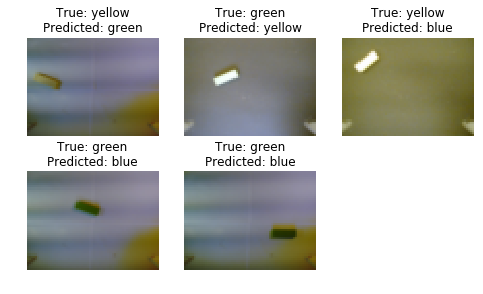

In [546]:
outtest = torch.max(net(torch.Tensor(test_images)),1)[1].detach().numpy()
idx = [i for i in range(len(outtest)) if outtest.data[i] != targets_test[i]]

print("Number of incorrect classifications in test set: ",len(idx))
numberofimages = len(idx)

imagesperline = 3
fig = plt.figure(figsize=(8, 4.5))
lines = numberofimages//imagesperline + (1 if numberofimages%imagesperline > 0 else 0)
for i in range(numberofimages):
    plt.subplot(lines, imagesperline, i+1)
    plt.imshow(np.moveaxis(test_images[idx][i],0,2))
    plt.title("True: {0}\nPredicted: {1}".format(colour_lookup[targets_test[idx][i]], colour_lookup[outtest[idx][i]]))
    plt.axis('off')

# Orientation estimation model

In [266]:
# make images grey scale
from skimage.color import rgb2gray

train_images_gray = np.array([rgb2gray(img) for img in np.moveaxis(np.array(train_images),1,3)])
valid_images_gray = np.array([rgb2gray(img) for img in np.moveaxis(np.array(valid_images),1,3)])
test_images_gray = np.array([rgb2gray(img) for img in np.moveaxis(np.array(test_images),1,3)])

# A channel size of 1 is required for conv, therefore one is added
train_images_gray = np.expand_dims(train_images_gray,1)
valid_images_gray = np.expand_dims(valid_images_gray,1)
test_images_gray = np.expand_dims(test_images_gray,1)
print("Shapes: ",train_images_gray.shape,valid_images_gray.shape,test_images_gray.shape)

Shapes:  (2806, 1, 48, 64) (351, 1, 48, 64) (351, 1, 48, 64)


## Design of edge detection filter layer

Parameter containing:
tensor([[[[ 0.3177, -0.0219, -0.0207],
          [ 0.0802, -0.0146,  0.3170],
          [ 0.0464, -0.0290, -0.0664]]],


        [[[ 0.3031,  0.0828, -0.2644],
          [ 0.0635, -0.1820,  0.1471],
          [-0.2970, -0.0293, -0.0124]]]], requires_grad=True)
Parameter containing:
tensor([[[[  3.,  10.,   3.],
          [  0.,   0.,   0.],
          [ -3., -10.,  -3.]]],


        [[[  3.,   0.,  -3.],
          [ 10.,   0., -10.],
          [  3.,   0.,  -3.]]]], requires_grad=True)
torch.Size([1, 1, 48, 64])
torch.Size([1, 2, 48, 64])
(48, 64)


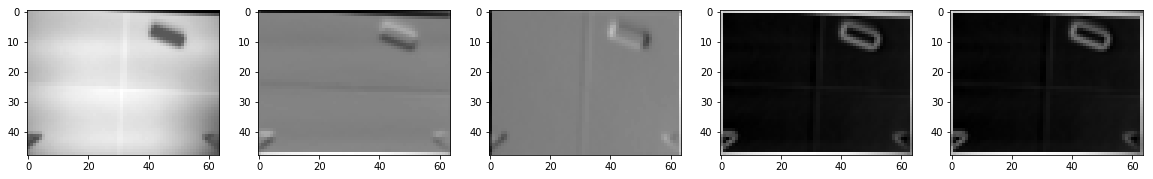

In [267]:
N____0 = 14 # image to print

## Sobel-Feldman filter 
edgevertfilter_Sobel_Feldman = [[1, -2, 1],[0, 0, 0],[-1, 2, -1]]
edgehorifilter_Sobel_Feldman = [[1, 0, -1],[2, 0, -2],[1, 0, -1]]
## Scharr filter (seems to detect edges more sharply)
edgevertfilter_Scharr = [[3, 10, 3],[0, 0, 0],[-3, -10, -3]]
edgehorifilter_Scharr = [[3, 0, -3],[10, 0, -10],[3, 0, -3]]

edge = Conv2d(in_channels=1,out_channels=2,kernel_size=3,stride=1,padding=1)

#print(edge.weight)
edge.weight.data = torch.Tensor([[edgevertfilter_Scharr],[edgehorifilter_Scharr]])
#print(edge.weight)
imgtest_before = torch.Tensor(np.expand_dims(train_images_gray[N____0],0))
#print(imgtest_before.shape)
imgtest_after = edge(imgtest_before)
#print(imgtest_after.shape)
plt.figure(figsize=(20,20))
plt.subplot(1, 5, 1)
plt.imshow(imgtest_before.numpy()[0,0,:,:], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(imgtest_after.detach().numpy()[0,0,:,:], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(imgtest_after.detach().numpy()[0,1,:,:], cmap='gray')
plt.subplot(1, 5, 4)
comb1 = imgtest_after.detach().numpy()[0,0,:,:]
comb2 = imgtest_after.detach().numpy()[0,1,:,:]
combined = np.sqrt(pow(comb1,2)+pow(comb2,2))
plt.imshow(combined, cmap='gray')
#print(combined.shape)

def edge_filter_func(x, edge_conv=edge):
    """
    performs horizontal and vertical edge filtering and combines both channels
    """
    ret = edge_conv(x)
    return torch.sqrt(torch.pow(ret[:,0,:,:],2)+torch.pow(ret[:,1:,:],2))

# Test of defined filter function
plt.subplot(1, 5, 5)
test = edge_filter_func(torch.Tensor(np.expand_dims(train_images_gray[N____0],0)))
plt.imshow(test.detach().numpy()[0,0,:,:], cmap='gray')

# sharpening
#sharpfilter = [[0, -1, 0],[-1, 100, -1],[0, -1, 0]]
#sharp = Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=1)
#sharp.weight.data = torch.Tensor([[sharpfilter]])
#combined_sharp = np.expand_dims(np.expand_dims(combined,0),0)
#combined_sharp = sharp(torch.Tensor(combined_sharp))
#plt.subplot(1, 5, 5)
#plt.imshow(combined_sharp.detach().numpy()[0,0,:,:], cmap='gray')

Colour: red
X=0.040257136411746525 m
Y=-0.010517700943062536 m
theta=1.1084452939206044 rads



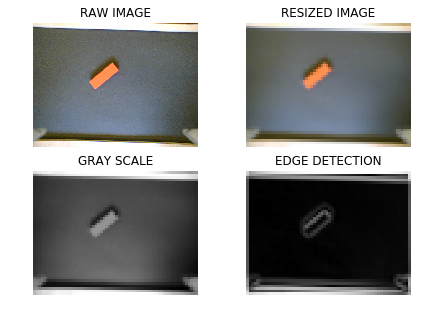

In [450]:
idx = 1
image = imread("Deep/pics/{0}.png".format(idx), as_gray=False)
print("Colour: {0}\nX={1} m\nY={2} m\ntheta={3} rads".format(colour_lookup[data.colour[idx]], data.x_pos[idx], data.y_pos[idx], data.theta[idx]))
fig = plt.figure(figsize=(7, 5))

plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(image)
plt.title('RAW IMAGE')

plt.subplot(2,2,2)
plt.axis('off')
image_resize = resize(image, output_shape=image_size[:2], mode='reflect', anti_aliasing=True)
plt.imshow(image_resize)
plt.title('RESIZED IMAGE')

plt.subplot(2,2,3)
plt.axis('off')
image_gray = rgb2gray(image_resize)
plt.imshow(image_gray, cmap='gray')
plt.title('GRAY SCALE')

plt.subplot(2,2,4)
plt.axis('off')
image_edge = edge_detect_helper(np.expand_dims(np.expand_dims(image_gray,0),0))[0,0,:,:]
plt.imshow(image_edge, cmap='gray')
plt.title('EDGE DETECTION')

print("")

### Difference between Sobel Feldman and Schar filters

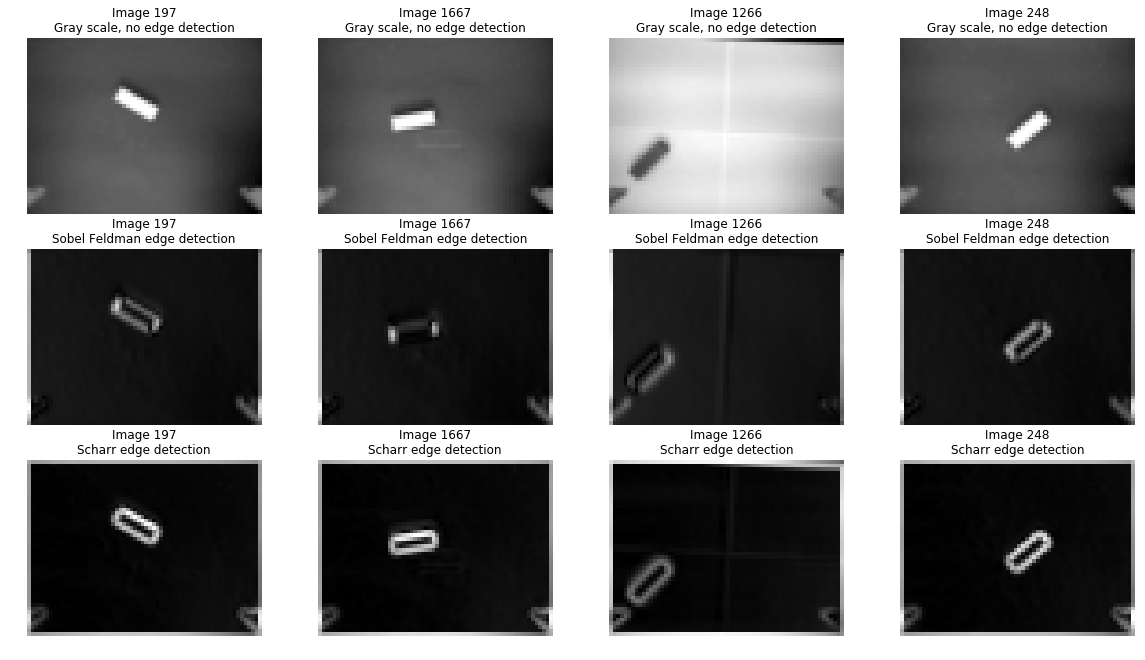

In [268]:
conv_sobel = Conv2d(in_channels=1,out_channels=2,kernel_size=3,stride=1,padding=1)
conv_schar = Conv2d(in_channels=1,out_channels=2,kernel_size=3,stride=1,padding=1)
conv_sobel.weight.data = torch.Tensor([[edgevertfilter_Sobel_Feldman],[edgehorifilter_Sobel_Feldman]])
conv_schar.weight.data = torch.Tensor([[edgevertfilter_Scharr],[edgehorifilter_Scharr]])

numberofimages = 4
imagesperline = 4

idx = np.random.choice(range(len(train_images_gray)),numberofimages)
sobel_set = edge_filter_func(torch.Tensor(train_images_gray[idx]),conv_sobel).detach().numpy()
scharr_set = edge_filter_func(torch.Tensor(train_images_gray[idx]),conv_schar).detach().numpy()

fig = plt.figure(figsize=(20, 11))
lines = 3
for i in range(imagesperline):
    plt.subplot(lines, imagesperline, i+1)
    plt.imshow(train_images_gray[idx][i][0], cmap='gray')
    plt.title("Image {0}\nGray scale, no edge detection".format(idx[i]))
    plt.axis('off')
for i in range(imagesperline):
    plt.subplot(lines, imagesperline, i+1+4)
    temp = np.expand_dims(train_images_gray[idx][i],0)
    temp = edge_filter_func(torch.Tensor(temp), conv_sobel)
    temp = temp.detach().numpy()[0][0]
    plt.imshow(temp, cmap='gray')
    plt.title("Image {0}\nSobel Feldman edge detection".format(idx[i]))
    plt.axis('off')
for i in range(imagesperline):
    plt.subplot(lines, imagesperline, i+1+(imagesperline*2))
    temp = np.expand_dims(train_images_gray[idx][i],0)
    temp = edge_filter_func(torch.Tensor(temp), conv_schar)
    temp = temp.detach().numpy()[0][0]
    plt.imshow(temp, cmap='gray')
    plt.title("Image {0}\nScharr edge detection".format(idx[i]))
    plt.axis('off')

(4, 1, 48, 64)


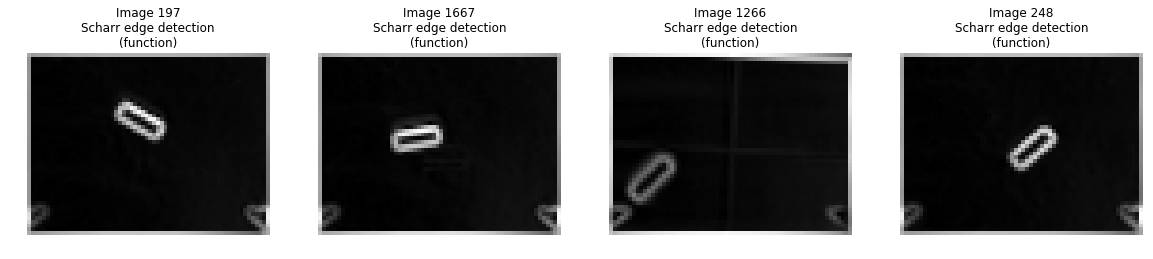

In [269]:
def edge_detect_helper(x, conv=conv_schar):
    """
    performs the edge_filter_func per element and returns a list
    """
    for i, img in enumerate(x):
        ret = x[i]
        ret = np.expand_dims(img,0)
        ret = edge_filter_func(torch.Tensor(ret), conv)
        x[i] = ret.detach().numpy()[0]
    return x
    
## Test of function
numberofimages = 4
imagesperline = 4
lines = 1
fig = plt.figure(figsize=(20, 11))
temp = edge_detect_helper(train_images_gray[idx])
print(temp.shape)
for i in range(imagesperline):
    plt.subplot(lines, imagesperline, i+1)
    plt.imshow(temp[i][0], cmap='gray')
    plt.title("Image {0}\nScharr edge detection\n(function)".format(idx[i]))
    plt.axis('off')

In [270]:
# Running the training data thorugh the edge detection
train_images_gray = edge_detect_helper(train_images_gray)
valid_images_gray = edge_detect_helper(valid_images_gray)
test_images_gray = edge_detect_helper(test_images_gray)
print("shapes: ",train_images_gray.shape,valid_images_gray.shape,test_images_gray.shape)

shapes:  (2806, 1, 48, 64) (351, 1, 48, 64) (351, 1, 48, 64)


In [607]:
"""
ORIENTATION ESTIMATION MODEL (REGRESSION)
"""

num_output = 3
channels = train_images_gray[0].shape[0]
height = train_images_gray[0].shape[1]
width = train_images_gray[0].shape[2]

conv1_out = 16*channels
conv1_kern = 3 # 5
conv1_stri = 1 # 1
conv1_pad = 0 # 2

maxp1_kern = 2
maxp1_stri = 2

conv2_out = 64
conv2_kern = 3
conv2_stri = 1

maxp2_kern = 2
maxp2_stri = 2

l1_out = 500

l2_out = 100

l3_out = 20
   
def compute_conv_dim(dim_size, kern_size, stride, padd = 0):
    return int((dim_size - kern_size + 2 * padd) / stride + 1)

class Net_Orientation_EST(nn.Module):

    def __init__(self):
        super(Net_Orientation_EST, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv1_out,
                             kernel_size=conv1_kern,
                             stride=conv1_stri,
                             padding=conv1_pad,
                             bias=False)
        
        self.maxp_1 = MaxPool2d(kernel_size=maxp1_kern,stride=maxp1_stri)
        
        self.conv_2 = Conv2d(in_channels=conv1_out,
                             out_channels=conv2_out,
                             kernel_size=conv2_kern,
                             stride=conv2_stri,
                             bias=False)
        
        self.maxp_2 = MaxPool2d(kernel_size=maxp2_kern,stride=maxp2_stri)
        
        h = height
        h = compute_conv_dim(height, conv1_kern, conv1_stri, conv1_pad) # conv1
        h = compute_conv_dim(h, maxp1_kern, maxp1_stri)      # maxp1
        h = compute_conv_dim(h, conv2_kern, conv2_stri)      # conv2
        h = compute_conv_dim(h, maxp2_kern, maxp2_stri)      # maxp2
        
        w = width
        w = compute_conv_dim(width, conv1_kern, conv1_stri, conv1_pad)  # conv1
        w = compute_conv_dim(w, maxp1_kern, maxp1_stri)      # maxp1
        w = compute_conv_dim(w, conv2_kern, conv2_stri)      # conv2
        w = compute_conv_dim(w, maxp2_kern, maxp2_stri)      # maxp2
        
        c = conv2_out                                        # last amount of channels
        
        self.fc = c * h * w
        
        self.l_1 = Linear(in_features=self.fc, out_features=l1_out, bias=False)
        
        self.l_2 = Linear(in_features=l1_out, out_features=l2_out, bias=False)
        
        self.l_3 = Linear(in_features=l2_out, out_features=l3_out, bias=False)
        
        self.l_out = Linear(in_features=l3_out, out_features=num_output, bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = relu(self.conv_1(x))
        x = self.maxp_1(x)
        
        x = relu(self.conv_2(x))
        x = self.maxp_2(x)
        
        x = x.view(-1, self.fc)
        x = self.l_1(x)
        x = F.softsign(x)
        x = F.dropout(x,0.5)
        
        x = self.l_2(x)
        x = F.softsign(x)
        x = F.dropout(x,0.25)
        
        x = self.l_3(x)
        x = F.softsign(x)
        
        x = self.l_out(x)
        return x


net_reg = Net_Orientation_EST()
print(net_reg)

Net_Orientation_EST(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (maxp_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (maxp_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_1): Linear(in_features=8960, out_features=500, bias=False)
  (l_2): Linear(in_features=500, out_features=100, bias=False)
  (l_3): Linear(in_features=100, out_features=20, bias=False)
  (l_out): Linear(in_features=20, out_features=3, bias=False)
)


In [608]:
criterion_reg = nn.L1Loss()
optimizer_reg = optim.Adam(net_reg.parameters(), lr=0.00001, weight_decay=0.0008)

In [609]:
#Test of the forward pass with dummy data
x = np.random.normal(0,1, (5, channels, image_size[0], image_size[1])).astype('float32')
out = net_reg(Variable(torch.from_numpy(x)))
print(out.size(), out)

torch.Size([5, 3]) tensor([[ 0.0175, -0.0458, -0.0031],
        [ 0.0229, -0.0647,  0.0106],
        [ 0.0224, -0.0569,  0.0083],
        [ 0.0312, -0.0667,  0.0057],
        [ 0.0294, -0.0539,  0.0013]], grad_fn=<MmBackward>)


Epoch  1 : Train Loss 0.202415 , Train err 4.601108%, Valid err 4.643439%
Epoch 13 : Train Loss 0.085105 , Train err 1.824137%, Valid err 1.714950%
Epoch 25 : Train Loss 0.079505 , Train err 1.739629%, Valid err 1.650764%
Epoch 37 : Train Loss 0.069503 , Train err 1.388868%, Valid err 1.374061%
Epoch 49 : Train Loss 0.037905 , Train err 0.486054%, Valid err 0.515065%
Epoch 61 : Train Loss 0.027696 , Train err 0.288704%, Valid err 0.308404%
Epoch 73 : Train Loss 0.023653 , Train err 0.243642%, Valid err 0.267636%
Epoch 85 : Train Loss 0.020734 , Train err 0.193783%, Valid err 0.216234%
Epoch 97 : Train Loss 0.019282 , Train err 0.166079%, Valid err 0.188744%
Epoch 109 : Train Loss 0.017328 , Train err 0.156202%, Valid err 0.179090%

Test set Err:  0.160723%


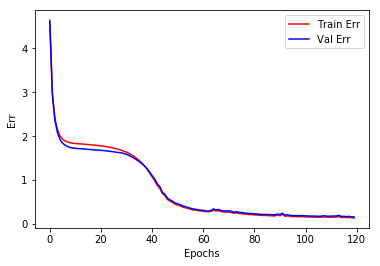

In [610]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

batch_size = 50
num_epochs = 120
num_epoch_prints = 50
num_samples_train = train_images_gray.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = valid_images_gray.shape[0]
num_batches_valid = num_samples_valid // batch_size

targets_train = y_train.values[:,1:4]
targets_valid = y_valid.values[:,1:4]
targets_test = y_test.values[:,1:4]

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net_reg.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train_images_gray[slce]).float())
        output = net_reg(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).float())
        batch_loss = criterion_reg(output, target_batch)
        optimizer_reg.zero_grad()
        batch_loss.backward()
        optimizer_reg.step()
        
        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)

    net_reg.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train_images_gray[slce]).float())
        
        output = net_reg(x_batch)
        preds = output
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(valid_images_gray[slce]).float())
        
        output = net_reg(x_batch)
        preds = output
        
        val_targs += list(targets_valid[slce])
        val_preds += list(preds.data.numpy())
        
    
    train_acc_cur = mean_absolute_error(train_targs, train_preds)
    valid_acc_cur = mean_absolute_error(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch*num_epoch_prints % num_epochs == 0:
        print("Epoch %2i : Train Loss %f , Train err %f%%, Valid err %f%%" % (
                epoch+1, losses[-1], train_acc_cur*100, valid_acc_cur*100))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, np.multiply(train_acc,100), 'r', epoch, np.multiply(valid_acc,100), 'b')
plt.legend(['Train Err', 'Val Err'])
plt.xlabel('Epochs')
plt.ylabel('Err')

### Evaluate test set
x_batch = Variable(torch.from_numpy(test_images_gray).float())
output = net_reg(x_batch)
preds = output
print("\nTest set Err:  %f%%" % ((mean_absolute_error(list(targets_test), list(preds.data.numpy())))*100))

In [611]:
## Manual check of test accuracy

acc = net_reg(torch.Tensor(test_images_gray))
deviations = []
for i in range(10):
    deviations = deviations + [acc.data.numpy()[i]/targets_test[i]]
    print("Predicted x and y: ",acc.data.numpy()[i]," \tTrue x and y: ",targets_test[i])
    
print("")
for idx in deviations:
    print("% deviation from true value (x,y):", idx)

Predicted x and y:  [-0.11672421 -0.05234321  1.0394862 ]  	True x and y:  [-0.11075322 -0.05294619  1.14427229]
Predicted x and y:  [0.02422475 0.03609145 0.64993143]  	True x and y:  [0.02500499 0.03175951 0.6691318 ]
Predicted x and y:  [4.170428e-02 2.822429e-04 1.027374e+00]  	True x and y:  [4.09319168e-02 1.05981370e-05 9.65077245e-01]
Predicted x and y:  [ 0.19866857 -0.09830001  0.5409717 ]  	True x and y:  [ 0.18812556 -0.0967114   0.55548979]
Predicted x and y:  [-0.03936916  0.01007876  0.9557201 ]  	True x and y:  [-0.03353082  0.01545997  0.95033384]
Predicted x and y:  [-0.03839471  0.06979898  1.08146   ]  	True x and y:  [-0.03900032  0.07093207  1.08005754]
Predicted x and y:  [0.02405892 0.03397728 0.546883  ]  	True x and y:  [0.02392715 0.03142207 0.62208512]
Predicted x and y:  [ 0.03553402 -0.01713638  0.588912  ]  	True x and y:  [ 0.03882895 -0.02345562  0.59761066]
Predicted x and y:  [0.03479471 0.00612128 0.8471678 ]  	True x and y:  [0.03460865 0.00103507 0

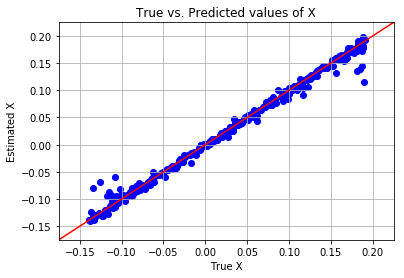

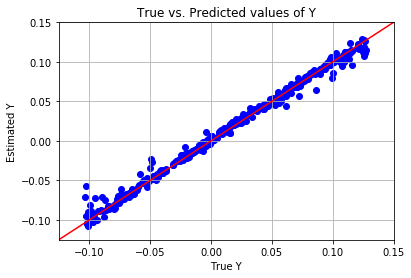

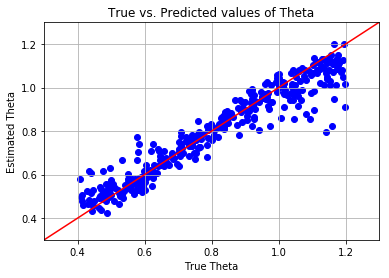

In [665]:
## Ploting

straightline = range(-10,10)

plt.figure()
plt.scatter(targets_test[:,0], acc.detach().numpy()[:,0], c='b')
plt.plot(straightline,straightline, 'r')
plt.xlim(-0.175,0.225)
plt.ylim(-0.175,0.225)
plt.xlabel('True X')
plt.ylabel('Estimated X')
plt.title('True vs. Predicted values of X')
plt.grid(True)

plt.figure()
plt.scatter(targets_test[:,1], acc.detach().numpy()[:,1], c='b')
plt.plot(straightline,straightline, 'r')
plt.xlim(-0.125,0.15)
plt.ylim(-0.125,0.15)
plt.xlabel('True Y')
plt.ylabel('Estimated Y')
plt.title('True vs. Predicted values of Y')
plt.grid(True)

plt.figure()
plt.scatter(targets_test[:,2], acc.detach().numpy()[:,2], c='b')
plt.plot(straightline,straightline, 'r')
plt.xlim(0.30,1.3)
plt.ylim(0.30,1.3)
plt.xlabel('True Theta')
plt.ylabel('Estimated Theta')
plt.title('True vs. Predicted values of Theta')
plt.grid(True)